In [43]:
# ==============================================
# Diffusion Model Training Notebook
# ==============================================
# Author: [Han Zhang]
# Date: [19/11/2024]
# Purpose: End-to-end demonstration of training a diffusion model on preliminary data
# ==============================================

In [44]:
# --- Import Necessary Libraries ---
import os  # For file handling
import csv # For saving data to CSV
from datetime import datetime # For timestamping
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualization
import scipy.io as sio  # For handling MATLAB .mat files
import torch  # PyTorch: deep learning framework
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functions for neural networks
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split # Data handling
from tqdm import tqdm  # Progress bar
from sklearn.preprocessing import MinMaxScaler  # Scaling data (optional)
#from segmentation_models_pytorch import Unet


In [45]:
# --- File Paths ---
# Define file paths (modify these for your datasets)
MATLAB_FILE_PATH = "A:/Research/Projects/Metamaterial Geometry Bandgap Dataset Generator/2D-dispersion/complete_datasets/complete_dataset_control_32pix.mat"  # Path to .mat file
MATLAB_FILE_PATH = "C:/Users/hz283/Documents/Duke/Research/2D-dispersion/complete_datasets/complete_dataset_control_32pix.mat"  # Path to .mat file

OUTPUT_DIRECTORY = "output/"  # Directory to save results/models

In [46]:
# Load the .mat file
data = sio.loadmat(MATLAB_FILE_PATH)

# Inspect the keys in the dictionary
print("Variables in the .mat file:", data.keys())

# Extract specific variables
designs_raw = data.get('designs')  # Replace 'designs' with your variable name
if designs_raw is not None:
    print("Designs raw shape:", designs_raw.shape)
else:
    print("Designs variable not found.")

bandgap_edges_raw = data.get('bandgap_edges')  # Replace 'bandgap_edges' with your variable name
if bandgap_edges_raw is not None:
    print("Bandgap edges raw shape:", bandgap_edges_raw.shape)
else:
    print("Bandgap_edges variable not found.")

# Reshape designs_raw, drop redundant 3rd dimension
designs = np.transpose(designs_raw, (3, 0, 1, 2))[..., 0]
print("Designs processed shape:", designs.shape)

# Reshape bandgap_edges_raw
bandgap_edges = np.transpose(bandgap_edges_raw, (2, 1, 0))
print("Bandgap edges processed shape:", bandgap_edges.shape)


Variables in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'DENSITY_DATA', 'EIGENVALUE_DATA', 'ELASTIC_MODULUS_DATA', 'POISSON_DATA', 'WAVEVECTOR_DATA', 'bandgap_edges', 'bandgaps', 'const', 'None', 'designs', '__function_workspace__'])
Designs raw shape: (32, 32, 3, 1000)
Bandgap edges raw shape: (2, 5, 1000)
Designs processed shape: (1000, 32, 32)
Bandgap edges processed shape: (1000, 5, 2)


In [47]:
def plot_sample_geometry(designs, bandgap_tops, bandgap_bottoms, index=0):
    """
    Plots a single sample geometry from the designs array with additional metadata.
    The title includes the index, bandgap top, and bandgap bottom values.
    The colorbar is adjusted to be the same height as the plot.
    
    Args:
    - designs (np.ndarray): Array containing the designs of shape (n, 32, 32).
    - index (int): Index of the sample to plot.
    - bandgap_tops (np.ndarray): Array of bandgap top values.
    - bandgap_bottoms (np.ndarray): Array of bandgap bottom values.
    """
    # Validate index
    if index < 0 or index >= designs.shape[0]:
        raise ValueError(f"Index {index} is out of bounds for designs array with shape {designs.shape}.")

    # Extract the geometry to plot
    sample_geometry = designs[index]

    # Metadata for the title
    top = bandgap_tops[index]
    bottom = bandgap_bottoms[index]

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(sample_geometry, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Index: {index}, Bandgap Top: {top:.2f}, Bottom: {bottom:.2f}")
    ax.axis("off")  # Remove axis ticks for cleaner visualization

    # Add a colorbar with adjusted height
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Fraction controls height, pad adjusts spacing
    cbar.set_label("Value")  # Label for the colorbar

    # Show the plot
    plt.show()

def extract_bandgap_edges(bandgap_edges, warn_threshold=1, zero_threshold=0.5):
    """
    Extracts the bandgap tops and bottoms for each geometry.
    Prints warnings for:
      - Rows with a single non-zero value.
      - Negative non-zero values.
      - Non-positive differences between top and bottom values.
      - Bandgap differences smaller than warn_threshold.
      - Bandgap set to 0 due to zero_threshold.

    Args:
    - bandgap_edges (np.ndarray): Array of shape (n, 5, 2) containing bandgap edges.
    - warn_threshold (float): Threshold for small bandgap warnings.
    - zero_threshold (float): Minimum difference for a valid bandgap. Below this, a different row is checked.

    Returns:
    - bandgap_tops (np.ndarray): Vector of length n containing the top edges of the bandgap.
    - bandgap_bottoms (np.ndarray): Vector of length n containing the bottom edges of the bandgap.
    """
    n = bandgap_edges.shape[0]  # Number of samples
    bandgap_tops = np.zeros(n)  # Initialize tops
    bandgap_bottoms = np.zeros(n)  # Initialize bottoms

    for i in range(n):
        # Extract the 5x2 array for the current sample
        edges = bandgap_edges[i]

        # Iterate over the rows to find a valid row
        valid_pair = False
        for row in edges:
            non_zero_count = np.count_nonzero(row)  # Count non-zero values in the row
            if non_zero_count == 2:
                # Check for negative non-zero values
                if any(value < 0 for value in row):
                    print(f"Warning: Negative values found in sample {i}, row: {row}")

                # Compute the bandgap top and bottom
                bottom, top  = row[0], row[1]
                difference = top - bottom

                # Check for non-positive difference
                if difference <= 0:
                    print(f"Warning: Non-positive difference in sample {i}, row: {row}")
                    continue  # Move to the next row

                # Check if the difference is between 0 and zero_threshold
                elif 0 < difference < zero_threshold:
                    print(f"Warning: Bandgap difference below zero_threshold ({zero_threshold}) in sample {i}, row: {row}, ignoring this bandgap.")
                    continue  # Skip this row and move to the next

                # Check if the difference is between zero_threshold and warn_threshold
                elif zero_threshold <= difference < warn_threshold:
                    print(f"Warning: Small bandgap detected at index {i}, value: {difference:.6f}, still recorded as valid bandgap.")

                # Assign values to bandgap_tops and bandgap_bottoms
                bandgap_tops[i] = top
                bandgap_bottoms[i] = bottom
                valid_pair = True
                break  # Exit the loop once a valid row is found
            elif non_zero_count == 1:
                # Row has a single non-zero value: print a warning
                print(f"Warning: Row with a single non-zero value detected in sample {i}: {row}")

        if not valid_pair:
            # No valid row found or all rows had differences below zero_threshold
            bandgap_tops[i] = 0
            bandgap_bottoms[i] = 0
            #print(f"Bandgap set to 0 for sample {i} due to zero_threshold ({zero_threshold}).")

    non_zero_count = np.count_nonzero(bandgap_tops)
    print(f"Number of non-zero bandgap_tops and bandgap_bottoms: {non_zero_count} out of {n}")
    return bandgap_tops, bandgap_bottoms

In [48]:
bandgap_tops, bandgap_bottoms = extract_bandgap_edges(bandgap_edges)

Number of non-zero bandgap_tops and bandgap_bottoms: 376 out of 1000


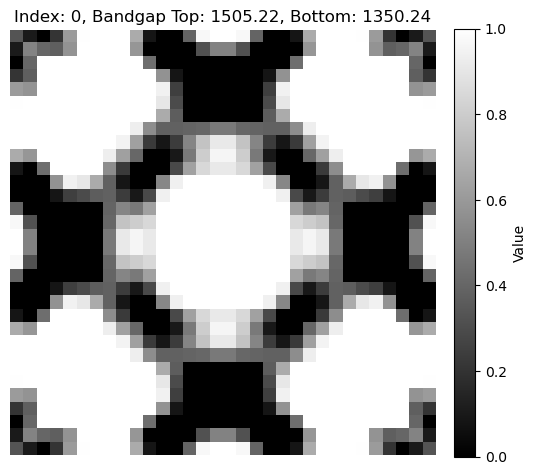

In [49]:
plot_sample_geometry(designs, bandgap_tops, bandgap_bottoms, index=0)

In [50]:
# --- Define Diffusion Model ---
class UNetWithTimeAndBandgap(nn.Module):
    """
    U-Net implementation with scalar timestep and bandgap conditioning for diffusion modeling.
    """
    def __init__(self, input_channels=1, output_channels=1, time_embedding_dim=128, condition_dim=128):
        """
        Initialize the U-Net model.
    
        Args:
        - input_channels (int): Number of input channels (e.g., 1 for geometry images).
        - output_channels (int): Number of output channels.
        - time_embedding_dim (int): Dimensionality of timestep embedding.
        - condition_dim (int): Dimensionality of bandgap condition embedding.
        """
        super(UNetWithTimeAndBandgap, self).__init__()
    
        # Time embedding layer
        self.time_embedding = nn.Sequential(
            nn.Linear(1, time_embedding_dim),  # Scalar t to vector
            nn.ReLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim)
        )
    
        # Bandgap condition embedding layer
        self.bandgap_embedding = nn.Sequential(
            nn.Linear(2, condition_dim),  # Two bandgap values (top, bottom)
            nn.ReLU(),
            nn.Linear(condition_dim, condition_dim)
        )


        # Encoder
        self.enc1 = self.conv_block(input_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, output_channels, kernel_size=1)
        self.embedding_projection = nn.Linear(time_embedding_dim, 1024)  # Match bottleneck channels

    def conv_block(self, in_channels, out_channels):
        """
        A convolutional block with two convolutional layers followed by ReLU activations.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        """
        An upconvolution (transposed convolution) layer for upsampling.
        """
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x, t, bandgap):
        # Embeddings
        t = t.unsqueeze(-1)  # Ensure t has the correct shape
        t_emb = self.time_embedding(t)  # Shape: (batch_size, 128)
        bandgap_emb = self.bandgap_embedding(bandgap)  # Shape: (batch_size, 128)
    
        # Debugging shape mismatch
        if t_emb.shape[1] != bandgap_emb.shape[1]:
            raise ValueError(f"Shape mismatch: t_emb has shape {t_emb.shape}, but bandgap_emb has shape {bandgap_emb.shape}")
    
        combined_emb = t_emb + bandgap_emb  # Shape: (batch_size, 128)
    
        # Validate embedding sizes
        assert combined_emb.shape[1] == self.embedding_projection.in_features, (
            f"Combined embedding dimension mismatch: expected {self.embedding_projection.in_features}, "
            f"got {combined_emb.shape[1]}"
        )
    
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
    
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        projected_emb = self.embedding_projection(combined_emb)  # Shape: (batch_size, 1024)
    
        # Correctly reshape to 4D
        batch_size, num_channels = projected_emb.shape  # Extract batch size and channels
        spatial_dims = bottleneck.shape[2:]  # Get (H, W) of the bottleneck
        projected_emb = projected_emb.view(batch_size, num_channels, 1, 1).expand(-1, -1, *spatial_dims)
    
        bottleneck = bottleneck + projected_emb
    
        # Decoder
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat((up4, enc4), dim=1))
        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))
        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))
        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))
    
        return self.final_conv(dec1)


In [51]:
# Define the forward diffusion process
def forward_diffusion_sample(x_0, t, noise=None):
    """
    Add Gaussian noise to input images based on the timestep.
    Args:
    - x_0 (torch.Tensor): Clean input images of shape (batch, channels, H, W).
    - t (torch.Tensor): Timestep scalar tensor of shape (batch,).
    - noise (torch.Tensor): Optional noise to add; otherwise, sampled from normal distribution.
    Returns:
    - x_t: Noisy image at timestep t.
    - noise: The added noise.
    """
    if noise is None:
        noise = torch.randn_like(x_0)  # Generate Gaussian noise
    alpha_t = (1 - t / t.max()).view(-1, 1, 1, 1)  # Linearly decreasing variance schedule
    x_t = alpha_t * x_0 + (1 - alpha_t) * noise  # Add noise proportional to alpha_t
    return x_t, noise

# Training function
def forward_diffusion_sample(x_0, t, noise=None):
    """
    Add Gaussian noise to input images based on the timestep.
    Args:
    - x_0 (torch.Tensor): Clean input images of shape (batch, channels, H, W).
    - t (torch.Tensor): Timestep scalar tensor of shape (batch,).
    - noise (torch.Tensor): Optional noise to add; otherwise, sampled from normal distribution.
    Returns:
    - x_t: Noisy image at timestep t.
    - noise: The added noise.
    """
    if noise is None:
        noise = torch.randn_like(x_0)  # Generate Gaussian noise
    alpha_t = (1 - t / t.max()).view(-1, 1, 1, 1)  # Linearly decreasing variance schedule
    x_t = alpha_t * x_0 + (1 - alpha_t) * noise  # Add noise proportional to alpha_t
    return x_t, noise

# Training function
def train_diffusion_model(
        model,
        train_dataloader,
        val_dataloader,
        num_timesteps=1000,
        epochs=20,
        device="cuda",
        output_folder="./models",
        save_intermediates=False,
        track_losses=True,
):
    """
    Train the diffusion model with optional intermediate model saving and loss tracking.
    """
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    criterion = nn.MSELoss()

    device = torch.device(device)
    model.to(device)
    model.train()

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Initialize lists to track losses
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        epoch_train_loss = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Train]") as pbar:
            for batch in pbar:
                images, bandgap_tops, bandgap_bottoms = batch
                images = images.to(device)
                bandgap_tops = bandgap_tops.to(device)
                bandgap_bottoms = bandgap_bottoms.to(device)

                # Ensure images have the correct channel dimension
                if images.ndim == 3:
                    images = images.unsqueeze(1)

                # Combine bandgap_tops and bandgap_bottoms into a single tensor
                bandgap_conditions = torch.stack([bandgap_tops, bandgap_bottoms], dim=1)

                # Sample random timesteps for the batch
                timesteps = torch.randint(1, num_timesteps + 1, (images.size(0),), device=device).float()

                # Forward diffusion process (add noise)
                noisy_images, noise = forward_diffusion_sample(images, timesteps)

                # Predict noise from the noisy images
                predicted_noise = model(noisy_images, timesteps, bandgap_conditions)

                # Compute loss
                loss = criterion(predicted_noise, noise)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update TQDM progress bar
                epoch_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        avg_train_loss = epoch_train_loss / len(train_dataloader)
        training_losses.append(avg_train_loss)

        # Validation Loss
        model.eval()  # Set model to evaluation mode
        epoch_val_loss = 0
        with torch.no_grad():
            with tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Validation]") as pbar:
                for batch in pbar:
                    images, bandgap_tops, bandgap_bottoms = batch
                    images = images.to(device)
                    bandgap_tops = bandgap_tops.to(device)
                    bandgap_bottoms = bandgap_bottoms.to(device)

                    if images.ndim == 3:
                        images = images.unsqueeze(1)

                    bandgap_conditions = torch.stack([bandgap_tops, bandgap_bottoms], dim=1)
                    timesteps = torch.randint(1, num_timesteps + 1, (images.size(0),), device=device).float()
                    noisy_images, noise = forward_diffusion_sample(images, timesteps)
                    predicted_noise = model(noisy_images, timesteps, bandgap_conditions)
                    val_loss = criterion(predicted_noise, noise)
                    epoch_val_loss += val_loss.item()
                    pbar.set_postfix(val_loss=val_loss.item())

        avg_val_loss = epoch_val_loss / len(val_dataloader)
        validation_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

        # Save model checkpoint
        if save_intermediates:
            model_path = os.path.join(output_folder, f"model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Saved intermediate model to {model_path}")

    # Save the final model
    final_model_path = os.path.join(output_folder, "model_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model to {final_model_path}")

    # Track losses
    if track_losses:
        # Save losses to CSV
        losses_csv_path = os.path.join(output_folder, "losses.csv")
        with open(losses_csv_path, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Epoch", "Train Loss", "Validation Loss"])
            for epoch, (train_loss, val_loss) in enumerate(zip(training_losses, validation_losses), start=1):
                writer.writerow([epoch, train_loss, val_loss])
        print(f"Saved losses to {losses_csv_path}")

        # Plot losses
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), training_losses, label="Training Loss")
        plt.plot(range(1, epochs + 1), validation_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt_path = os.path.join(output_folder, "loss_plot.png")
        plt.savefig(plt_path)
        print(f"Saved loss plot to {plt_path}")
        plt.show()

In [52]:
# Create Dataset
batch_size = 64
images = torch.tensor(designs, dtype=torch.float32)
bandgap_tops = torch.tensor(bandgap_tops, dtype=torch.float32)
bandgap_bottoms = torch.tensor(bandgap_bottoms, dtype=torch.float32)

dataset = TensorDataset(images, bandgap_tops, bandgap_bottoms)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [53]:
# Initialize the model

input_channels = 1  # Single channel for geometry images
output_channels = 1  # Single channel for noise prediction
time_embedding_dim = 128  # Dimensionality of timestep embedding
condition_dim = 128  # Dimensionality of bandgap condition embedding

model = UNetWithTimeAndBandgap(
    input_channels=input_channels, 
    output_channels=output_channels, 
    time_embedding_dim=time_embedding_dim, 
    condition_dim=condition_dim
)


Epoch 1/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 216.13it/s, val_loss=0.971]


Epoch 1/20, Train Loss: 0.989637, Validation Loss: 0.957122
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_1.pth


Epoch 2/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 210.54it/s, val_loss=0.809]


Epoch 2/20, Train Loss: 0.913234, Validation Loss: 0.834043
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_2.pth


Epoch 3/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 235.32it/s, val_loss=0.647]


Epoch 3/20, Train Loss: 0.726919, Validation Loss: 0.623731
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_3.pth


Epoch 4/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 180.27it/s, val_loss=0.528]


Epoch 4/20, Train Loss: 0.502257, Validation Loss: 0.413353
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_4.pth


Epoch 5/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 181.83it/s, val_loss=0.235]


Epoch 5/20, Train Loss: 0.353294, Validation Loss: 0.306407
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_5.pth


Epoch 6/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 210.53it/s, val_loss=0.365]


Epoch 6/20, Train Loss: 0.295356, Validation Loss: 0.324506
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_6.pth


Epoch 7/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 210.16it/s, val_loss=0.355]


Epoch 7/20, Train Loss: 0.294171, Validation Loss: 0.291916
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_7.pth


Epoch 8/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 210.26it/s, val_loss=0.171]


Epoch 8/20, Train Loss: 0.280461, Validation Loss: 0.228359
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_8.pth


Epoch 9/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 209.31it/s, val_loss=0.194]


Epoch 9/20, Train Loss: 0.266346, Validation Loss: 0.251275
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_9.pth


Epoch 10/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 235.27it/s, val_loss=0.29]


Epoch 10/20, Train Loss: 0.231720, Validation Loss: 0.261782
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_10.pth


Epoch 11/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 210.53it/s, val_loss=0.181]


Epoch 11/20, Train Loss: 0.237722, Validation Loss: 0.237884
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_11.pth


Epoch 12/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 221.82it/s, val_loss=0.274]


Epoch 12/20, Train Loss: 0.237815, Validation Loss: 0.248206
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_12.pth


Epoch 13/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 233.36it/s, val_loss=0.288]


Epoch 13/20, Train Loss: 0.227938, Validation Loss: 0.231572
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_13.pth


Epoch 14/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 235.30it/s, val_loss=0.144]


Epoch 14/20, Train Loss: 0.208546, Validation Loss: 0.186355
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_14.pth


Epoch 15/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 209.06it/s, val_loss=0.203]


Epoch 15/20, Train Loss: 0.214147, Validation Loss: 0.223601
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_15.pth


Epoch 16/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 228.38it/s, val_loss=0.0568]


Epoch 16/20, Train Loss: 0.209757, Validation Loss: 0.205072
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_16.pth


Epoch 17/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 234.28it/s, val_loss=0.307]


Epoch 17/20, Train Loss: 0.214370, Validation Loss: 0.219801
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_17.pth


Epoch 18/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 234.04it/s, val_loss=0.295]


Epoch 18/20, Train Loss: 0.195832, Validation Loss: 0.221071
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_18.pth


Epoch 19/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 245.29it/s, val_loss=0.214]


Epoch 19/20, Train Loss: 0.184813, Validation Loss: 0.205311
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_19.pth


Epoch 20/20 [Validation]: 100%|██████████| 4/4 [00:00<00:00, 217.30it/s, val_loss=0.329]


Epoch 20/20, Train Loss: 0.195288, Validation Loss: 0.225354
Saved intermediate model to ./diffusion_models\20241120_142926\model_epoch_20.pth
Saved final model to ./diffusion_models\20241120_142926\model_final.pth
Saved losses to ./diffusion_models\20241120_142926\losses.csv
Saved loss plot to ./diffusion_models\20241120_142926\loss_plot.png


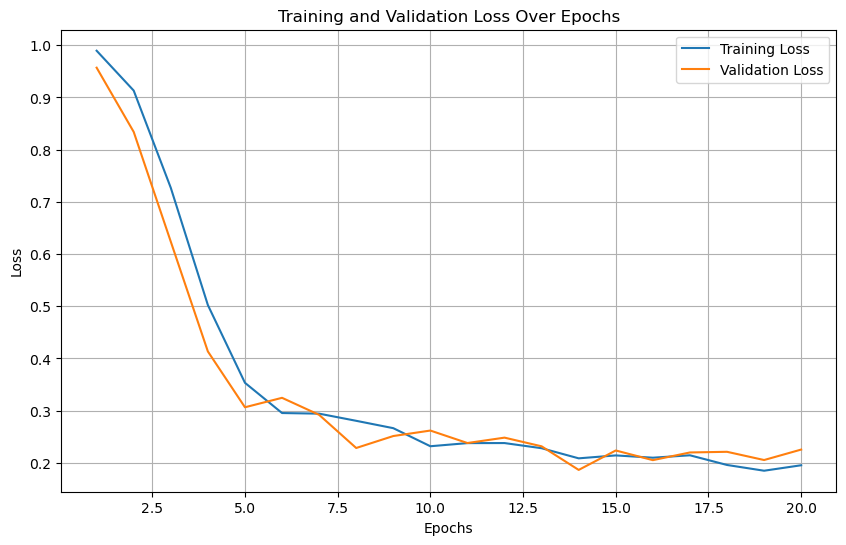

In [54]:
# Get a timestamp for the training session
training_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define the output folder
output_folder = os.path.join("./diffusion_models", training_timestamp)

# Train the model
train_diffusion_model(
    model,
    train_dataloader,
    val_dataloader,
    num_timesteps=200,
    epochs=20,
    device="cuda",
    output_folder=output_folder,
    save_intermediates=True,
    track_losses=True,
)

In [55]:
def generate_image(model, bandgap_top, bandgap_bottom, num_timesteps=200, device="cuda", image_size=32):
    """
    Generate an image given bandgap conditions using the trained diffusion model.
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    # Initialize Gaussian noise
    x_t = torch.randn(1, 1, image_size, image_size, device=device)  # Start with pure noise

    # Create conditioning tensors
    bandgap_conditions = torch.tensor([[bandgap_top, bandgap_bottom]], dtype=torch.float32, device=device)
    t_tensor = torch.tensor([[num_timesteps]], dtype=torch.float32, device=device)

    # Process bandgap and time embeddings using the model's embedding layers
    bandgap_emb = model.bandgap_embedding(bandgap_conditions)  # Shape: (1, 128)
    t_emb = model.time_embedding(t_tensor)  # Shape: (1, 128)
    combined_emb = bandgap_emb + t_emb  # Combine embeddings

    # Project combined embedding to match bottleneck channels
    projected_emb = model.embedding_projection(combined_emb).view(1, 1024, 1, 1)  # Shape: (1, 1024, 1, 1)

    # Iterative reverse diffusion process
    with torch.no_grad():
        for t in range(num_timesteps, 0, -1):
            t_tensor = torch.tensor([[t]], dtype=torch.float32, device=device)  # Update timestep tensor
            predicted_noise = model(x_t, t_tensor, bandgap_conditions)  # Predict noise
            alpha_t = torch.tensor(1 - t / num_timesteps, device=device)  # Compute alpha_t
            x_t = (x_t - (1 - alpha_t) * predicted_noise) / alpha_t.clamp(min=1e-6)  # Update x_t

    # Final denoised image
    final_image = x_t.clamp(0, 1)  # Clamp to [0, 1] for visualization

    return final_image.cpu()

def plot_generated_image(image_tensor, bandgap_top, bandgap_bottom, title=None, save_path=None):
    """
    Plot a generated image from a diffusion model output with metadata in the title.
    The title includes the bandgap top and bandgap bottom values.
    The colorbar is adjusted to be the same height as the plot.
    
    Args:
    - image_tensor (torch.Tensor): The generated image tensor of shape (1, 1, H, W).
    - bandgap_top (float): Bandgap top value.
    - bandgap_bottom (float): Bandgap bottom value.
    - title (str): Optional title for the plot. If None, a default title is created.
    - save_path (str): Optional path to save the plot as an image file.
    """
    # Remove batch and channel dimensions
    image = image_tensor.squeeze(0).squeeze(0).cpu().numpy()  # Shape: (H, W)

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(image, cmap='gray', vmin=0, vmax=1)

    # Add title with metadata
    if title is None:
        title = f"Generated Image\nBandgap Top: {bandgap_top:.2f}, Bottom: {bandgap_bottom:.2f}"
    ax.set_title(title)
    ax.axis("off")  # Remove axis ticks for cleaner visualization

    # Add a colorbar with adjusted height
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Value")  # Label for the colorbar

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved plot to {save_path}")
    else:
        plt.show()

In [56]:
bandgap_top = 1800
bandgap_bottom = 1500
generated_image = generate_image(model, bandgap_top, bandgap_bottom)
print(generated_image.shape)

# Plot the generated image
plot_generated_image(
    generated_image,
    bandgap_top=bandgap_top,
    bandgap_bottom=bandgap_bottom,
    title=None,
    save_path="generated_image_with_metadata.png"
)


ValueError: Shape mismatch: t_emb has shape torch.Size([1, 1, 128]), but bandgap_emb has shape torch.Size([1, 128])

In [ ]:
generated_image